In [34]:
import funclib as flib

Read data

In [35]:
directory = "../../data"

# Germline DNMs
pedigree_rates = pd.read_csv("{}/dnm_est_mutrate.tsv".format(directory),sep="\t")
pedigree_rates = pedigree_rates[pedigree_rates["Common Name"]!="Mouse lemur"].reset_index(drop=True)

# Crypts from Cagan et al.
crypt_muts = pd.read_csv("{}/crypt_rates.tsv".format(directory),sep=",")
crypt_muts["genome_size"] = 3e9
crypt_muts["rate"] = crypt_muts.muts_per_year/(crypt_muts.genome_size)
crypt_rates = crypt_muts.set_index("species")["rate"].to_dict()

Calculate yearly mutation rate in sperm, given a rate of mutation in Early of 5/3e9 and ratio of paternal-to-maternal parental age effects of 4

In [39]:
pedigree_sperm_rates = {}

#pred_crypt_rates = {}
#lifespan = pd.read_csv("{}/lifespan.txt".format(directory)).set_index("species")["lifespan"].to_dict()

E = 5/3e9
for cn,df in pedigree_rates.groupby("Common Name"):
    
    # Collapse DNMs from same species
    p = df["Pat DNMs"].sum()
    m = df["Mat DNMs"].sum()
    p_age = np.average(df["Mean Paternal Age at Conception (y)"].values, weights=df["Num Trios"])
    m_age = np.average(df["Mean Maternal Age at Conception (y)"].values, weights=df["Num Trios"])
    alpha = p/m
    sp = "_".join(df["Species"].values[0].split()[:2])
    gen_rate = np.average(df["Mutation rate per generation"].values, weights=df["Num Trios"]) #df["Mutation rate per generation"].mean()
    trios = df["Num Trios"].sum()

    # Predict age effects
    mu_f, mu_m = flib.get_parental_age_effects(gen_rate, m_age, p_age, E, 4)
    pedigree_sperm_rates[sp] = mu_m
    
    # Predict crypt rate
    #if sp in lifespan and sp not in crypt_rates:
    #    pred_crypt_rates[sp] = 3206.4/lifespan[sp]/3e9

Plot

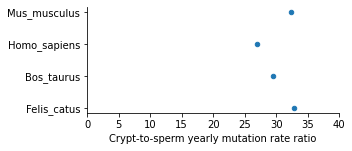

In [76]:
f,ax = plt.subplots(figsize=[5,2.2])

# Plotting
y = 0
ylabels = []

for sp,sperm_rate in pedigree_sperm_rates.items():
    if sp in crypt_rates:
        ax.scatter(crypt_rates[sp]/sperm_rate, y, color="C0", s=20)
        ylabels.append(sp)
        y += 1

# Styling
ax.set_yticks(range(len(ylabels)))
ax.set_yticklabels(ylabels)

ax.set_xlabel("Crypt-to-sperm yearly mutation rate ratio")
ax.set_xlim([0,40])

plt.tight_layout()
sns.despine()
plt.savefig("../pdfs/Figure_SX_cryptsperm_ratio.pdf")